# Hemodynamic AKI Modeling (Gradient Boosting + SHAP)

This notebook trains and evaluates **three gradient-boosting models** (XGBoost, LightGBM, CatBoost) for postoperative AKI prediction using:

- **Baseline features** (EHR only)
- **Extended features** (EHR + hemodynamic exposure features)

Models:
- XGBoost
- LightGBM
- CatBoost

It generates manuscript Fig3.

**Before running:** edit the paths in the **Configuration** cell below.


In [ ]:
# =========================
# Configuration + imports
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap
import warnings
from io import BytesIO
from PIL import Image

# ---- Paths and Column names ----
OUT_CSV = Path(r"/path/to/publication_features.csv")
ID_COL = "pat_enc_csn_sid"
TARGET = "aki_by_labs"

# -------------------------
# Hemodynamic feature columns
# -------------------------
HEMO_COLS = [
    "AUC_MAP_lt65_mmHg_min",
    "time_joint_MAP_lt65_CI_lt2_2_min",
    "time_joint_MAP_ge65_CI_ge2_2_min",
    "time_joint_MAP_lt65_CI_ge2_2_min",
    "time_joint_MAP_ge65_CI_lt2_2_min",
]

# Reproducibility / compute
SEED = 42
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

## Load data (analysis-ready)

In [2]:
df = pd.read_csv(OUT_CSV)

if TARGET not in df.columns:
    raise ValueError(f"Missing outcome column '{TARGET}' in {OUT_CSV}")
if ID_COL not in df.columns:
    raise ValueError(f"Missing ID column '{ID_COL}' in {OUT_CSV}")

missing_hemo = [c for c in HEMO_COLS if c not in df.columns]
if missing_hemo:
    raise ValueError(f"Missing hemodynamic columns in OUT_CSV: {missing_hemo}")

print(f"Loaded: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"AKI prevalence: {df[TARGET].mean():.3f}")


Loaded: 1972 rows x 45 columns
AKI prevalence: 0.185


## Define baseline vs extended features, preprocess and train/test split

In [3]:
# === Define X and y for both cases ===
X_base = df.drop(columns=[TARGET, ID_COL])
X_base = X_base.drop(columns=HEMO_COLS)
X_all = df.drop(columns=[TARGET, ID_COL])
y = df[TARGET]

# === Preprocess baseline ===
cat_base = X_base.select_dtypes(include=["object", "category"]).columns.tolist()
num_base = X_base.select_dtypes(include=["number"]).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_base_cat = encoder.fit_transform(X_base[cat_base])
X_base_num = X_base[num_base]
X_base_df = pd.DataFrame(np.hstack([X_base_num, X_base_cat]), columns=num_base + list(encoder.get_feature_names_out(cat_base)))

# === Preprocess extended ===
cat_all = X_all.select_dtypes(include=["object", "category"]).columns.tolist()
num_all = X_all.select_dtypes(include=["number"]).columns.tolist()
X_all_cat = encoder.fit_transform(X_all[cat_all])
X_all_num = X_all[num_all]
X_all_df = pd.DataFrame(np.hstack([X_all_num, X_all_cat]), columns=num_all + list(encoder.get_feature_names_out(cat_all)))

# === Train-test split ===
X_train_base, X_test_base, y_train, y_test = train_test_split(X_base_df, y, stratify=y, test_size=0.2, random_state=SEED)
X_train_all, X_test_all, _, _ = train_test_split(X_all_df, y, stratify=y, test_size=0.2, random_state=SEED)

## Final paired evaluation on test + paired bootstrap ΔAUROC CI

In [4]:
# === Bootstrap AUC comparison function ===
def bootstrap_auc_diff(y_true, pred1, pred2, n=1000):
    diffs = []
    for i in range(n):
        idx = resample(np.arange(len(y_true)), replace=True, random_state=42+i)
        auc1 = roc_auc_score(y_true[idx], pred1[idx])
        auc2 = roc_auc_score(y_true[idx], pred2[idx])
        diffs.append(auc2 - auc1)
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_val = (np.sum(np.array(diffs) <= 0) + 1) / (n + 1) * 2
    return ci_low, ci_high, p_val

def bootstrap_auc_ci(y_true, y_pred, n_bootstraps=1000):
    aucs = []
    for i in range(n_bootstraps):
        idx = resample(np.arange(len(y_true)), replace=True, random_state=1000 + i)
        aucs.append(roc_auc_score(y_true[idx], y_pred[idx]))
    ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])
    return ci_low, ci_high

# === Model definitions
models = {}

# XGBoost
xgb_params = {
    "colsample_bytree": 1, "learning_rate": 0.03, "max_depth": 5, "n_estimators": 300, 'min_child_weight': 5,
    "reg_alpha": 0.5, "reg_lambda": 0.5, "subsample": 1, "eval_metric": "auc", "random_state": 42,
    'objective': 'binary:logistic', 'tree_method': 'hist', 'n_jobs': -1
}
models["XGBoost"] = {
    "baseline": XGBClassifier(**xgb_params).fit(X_train_base, y_train),
    "extended": XGBClassifier(**xgb_params).fit(X_train_all, y_train)
}

# CatBoost
cat_params = { 'iterations': 200, 'learning_rate': 0.05, 'depth': 5, 'eval_metric': 'AUC', 
    'l2_leaf_reg': 0.5, 'subsample': 0.6, 'verbose': 0, 'random_state': 42
}
models["CatBoost"] = {
    "baseline": CatBoostClassifier(**cat_params).fit(X_train_base, y_train),
    "extended": CatBoostClassifier(**cat_params).fit(X_train_all, y_train)
}

# LightGBM
lgb_params = {
    "n_estimators": 300, "learning_rate": 0.03, "max_depth": 5, 'min_child_samples': 40, 'colsample_bytree': 0.8, 
    "num_leaves": 31, "reg_alpha": 0, "reg_lambda": 2, "random_state": 42, "verbose": -1,
    'objective': 'binary', 'metric': 'auc', 'n_jobs': -1, 'subsample': 0.8
}
models["LightGBM"] = {
    "baseline": LGBMClassifier(**lgb_params).fit(X_train_base, y_train),
    "extended": LGBMClassifier(**lgb_params).fit(X_train_all, y_train)
}

# === Evaluation
results = []

for model_name, pair in models.items():
    # Predict
    pred_b = pair["baseline"].predict_proba(X_test_base)[:, 1]
    pred_e = pair["extended"].predict_proba(X_test_all)[:, 1]

    # AUC and CIs
    auc_b = roc_auc_score(y_test, pred_b)
    auc_e = roc_auc_score(y_test, pred_e)
    auc_b_ci_low, auc_b_ci_high = bootstrap_auc_ci(y_test.values, pred_b)
    auc_e_ci_low, auc_e_ci_high = bootstrap_auc_ci(y_test.values, pred_e)

    # AUC gain
    ci_low, ci_high, p_val = bootstrap_auc_diff(y_test.values, pred_b, pred_e)
    pct_improvement = ((auc_e - auc_b) / auc_b) * 100 if auc_b > 0 else np.nan

    # Append results
    results.append({
        "Model": model_name,
        "AUROC_Baseline": auc_b,
        "Baseline_CI": f"{auc_b_ci_low:.3f}-{auc_b_ci_high:.3f}",
        "AUROC_Extended": auc_e,
        "Extended_CI": f"{auc_e_ci_low:.3f}-{auc_e_ci_high:.3f}",
        "AUC_Gain": auc_e - auc_b,
        "Pct_Improvement": pct_improvement,
        "CI_Low": ci_low,
        "CI_High": ci_high,
        "p_value": p_val
    })

results_df = pd.DataFrame(results)
print(results_df)


      Model  AUROC_Baseline  Baseline_CI  AUROC_Extended  Extended_CI  AUC_Gain  Pct_Improvement    CI_Low   CI_High   p_value
0   XGBoost        0.779418  0.725-0.831        0.804433  0.748-0.854  0.025015         3.209432  0.000360  0.051146  0.051948
1  CatBoost        0.777036  0.721-0.827        0.808942  0.748-0.857  0.031907         4.106214  0.006806  0.058529  0.007992
2  LightGBM        0.779758  0.726-0.831        0.802986  0.745-0.854  0.023228         2.978886  0.000507  0.048300  0.045954


## SHAP plot for the best extended model

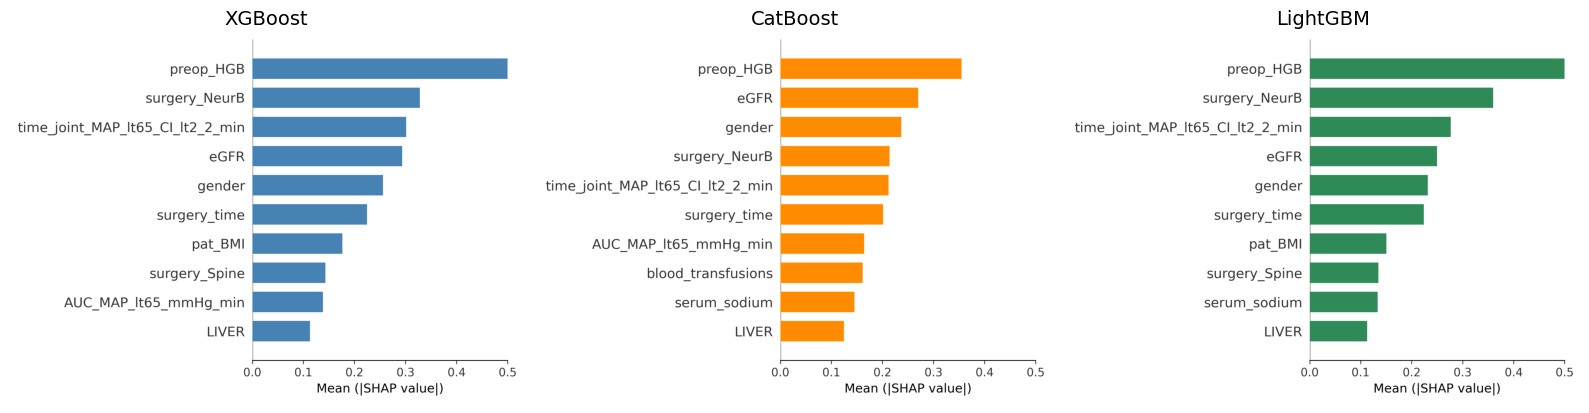

In [5]:
# Consistent model order and colors
MODEL_ORDER = ["XGBoost", "CatBoost", "LightGBM"]
MODEL_COLORS = {
    "XGBoost": "steelblue",
    "CatBoost": "darkorange",
    "LightGBM": "seagreen"
}

def _get_shap_values(explainer, X):
    """Handle binary vs. multiclass return shapes from shap_values()."""
    sv = explainer.shap_values(X)
    # If multiclass, pick positive class (index 1) by convention
    if isinstance(sv, list) and len(sv) == 2:
        return sv[1]
    return sv

def make_shap_bar_triptych(models, X_test_all, top_n=10, dpi=300):
    # Collect each model's SHAP bar plot as an image
    shap_images = []

    for model_name in MODEL_ORDER:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, module=r"shap\.explainers\._tree")
            model = models[model_name]["extended"]
            explainer = shap.TreeExplainer(model)
            shap_vals = _get_shap_values(explainer, X_test_all)

            # Draw SHAP bar plot (on a temporary figure)
            plt.figure()
            shap.summary_plot(
                shap_vals,
                X_test_all,
                plot_type="bar",
                max_display=top_n,
                show=False
            )

            # Recolor bars
            ax = plt.gca()
            for bar in ax.patches:
                bar.set_facecolor(MODEL_COLORS[model_name])
            ax.set_xlabel("Mean (|SHAP value|)", fontsize=12)
            ax.set_ylabel("")  # cleaner look

            plt.xlim(0, 0.5)

            # Save to buffer -> PIL Image
            buf = BytesIO()
            plt.gcf().set_size_inches(6, 5)
            plt.gcf().savefig(buf, format="png", bbox_inches="tight", dpi=dpi)
            buf.seek(0)
            shap_images.append(Image.open(buf))
            plt.close()

    # Stitch into one figure (1x3)
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    for ax, img, title in zip(axes, shap_images, MODEL_ORDER):
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.savefig(f"SHAP_barplot.jpg", dpi=300)
    plt.show()

# === Call it ===
make_shap_bar_triptych(models, X_test_all, top_n=10, dpi=300)
